# STYLE TRANSFER

In [37]:
from keras.preprocessing.image import load_img, img_to_array
from scipy.misc import imsave
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
import argparse

from keras import applications
from keras import backend as K

In [38]:
img_width = 300
img_height = 300
content_weight = 0.025  # the weight given to content loss
style_weight = 1.0    # the weight given to style loss
tv_weight = 1.0     # the weight given to total variance loss

In [39]:
# load image and convert to a format acceptable by vgg16
# vgg expect BGR instead of RGB and means to be deducted from each channel

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_width,img_height))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = applications.vgg16.preprocess_input(img)
    return img

In [68]:
# vgg expects the images in a certain format, so after converting
# to that format, you have to convert them back to display and save

def deprocess_image(x):
    x = x.reshape((img_width,img_height, 3))
    
    # remove zero center by mean pixel
    x[:,:,0] += 103.939
    x[:,:,1] += 116.779
    x[:,:,2] += 123.68
    
    #BGR -> RGB
    x = x[:,:,::-1]
    x = np.clip(x,0,255).astype('uint8')
    return x

In [41]:
# this is just to test and see the shape this function returns

# place a content.jpg and style.jpg file in your folder

preprocess_image('content.jpg').shape

(1, 300, 300, 3)

In [42]:
# get tensor representations of our images
base_image = K.variable(preprocess_image('content.jpg'))
style_reference_image = K.variable(preprocess_image('style.jpg'))

In [43]:
base_image

In [44]:
combination_image = K.placeholder((1,img_width,img_height,3))

In [45]:
combination_image

<tf.Tensor 'Placeholder_27:0' shape=(1, 300, 300, 3) dtype=float32>

In [46]:
# combine the 3 images into a single tensor
input_tensor = K.concatenate([base_image, style_reference_image, combination_image], axis=0)

In [47]:
input_tensor.get_shape()

TensorShape([Dimension(3), Dimension(300), Dimension(300), Dimension(3)])

In [48]:
# build the vgg16 network with 3 images as input
# load pretrained image net weights

model = applications.VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)

In [49]:
# get outputs of each layer from the model

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

In [50]:
outputs_dict # lists output of all the layers in the vgg16 network

{'block1_conv1': <tf.Tensor 'block1_conv1_1/Relu:0' shape=(3, 300, 300, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2_1/Relu:0' shape=(3, 300, 300, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool_1/MaxPool:0' shape=(3, 150, 150, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1_1/Relu:0' shape=(3, 150, 150, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2_1/Relu:0' shape=(3, 150, 150, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool_1/MaxPool:0' shape=(3, 75, 75, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1_1/Relu:0' shape=(3, 75, 75, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2_1/Relu:0' shape=(3, 75, 75, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3_1/Relu:0' shape=(3, 75, 75, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool_1/MaxPool:0' shape=(3, 37, 37, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1_1/Relu:0' shape=(3, 37, 37, 512) dtype

In [51]:
# define util functions for neural style loss

# gram matrix of image tensor
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2,0,1)))
    gram = K.dot(features, K.transpose(features))
    return gram

In [52]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels= 3
    size = img_width*img_height
    return K.sum(K.square(S-C))/(4.*(channels**2)*(size**2))

In [53]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

In [54]:
def total_variation_loss(x):
    a = K.square(x[:,:img_width-1,:img_height-1,:]- x[:,1:,:img_width-1,:])
    b = K.square(x[:,:img_width-1,:img_height-1,:]- x[:,:img_height-1,1:,:])
    return K.sum(K.pow(a+b, 1.25))
    

In [55]:
# combine loss into a single scalar

loss = K.variable(0.)
layer_features = outputs_dict['block4_conv2']

base_image_features = layer_features[0, :,:,:]
combination_features = layer_features[2,:,:,:]

# add content loss
loss += content_weight * content_loss(base_image_features, combination_features)

In [56]:
feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']

In [57]:
# add style loss

for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1,:,:,:]
    combination_features = layer_features[2,:,:,:]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight/ len(feature_layers))*sl

# add total variance loss
loss += tv_weight * total_variation_loss(combination_image)

In [58]:
# get gradients of generated image wrt loss

grads = K.gradients(loss, combination_image)

In [59]:
# create array of loss, followed by gradients

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

In [60]:
f_outputs = K.function([combination_image], outputs)

In [61]:
# helper function to find loss and gradients

def eval_loss_and_grads(x):

    x = x.reshape((1,img_width, img_height, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

In [62]:
# helper class to display information at 
# different stages while the model is training

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [63]:
evaluator = Evaluator()

In [64]:
# randomly initialize the combination image to a random
# set of pixels

x = np.random.uniform(0, 255, (1, img_width, img_height, 3)) - 128.

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline

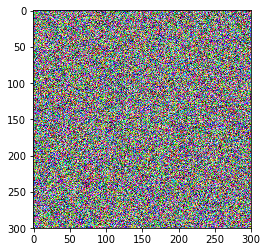

In [66]:
# display initial random image
# this image will become the final combined image after optimization
display_x = np.reshape(x, (img_width, img_height, 3))
plt.imshow(display_x)

In [69]:
for i in range(10):
    print("Start of iteration", i)
    start_time = time.time()
    
    # use l-bfgs algorithm which is more efficient than regular gradient descent
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                    fprime=evaluator.grads, maxfun=20)
    print('Current loss value', min_val)
    #save generated image
    img = deprocess_image(x.copy())
    fname = 'result_at_iteration%d.png'%i
    imsave(fname, img)
    end_time = time.time()
    print("Image saved as", fname)
    print("End of iteration %d in %d secs" % (i,end_time - start_time))

Start of iteration 0
Current loss value 3.24612e+09
Image saved as result_at_iteration0.png
End of iteration 0 in 158 secs
Start of iteration 1
Current loss value 2.89858e+09
Image saved as result_at_iteration1.png
End of iteration 1 in 162 secs
Start of iteration 2
Current loss value 2.73197e+09
Image saved as result_at_iteration2.png
End of iteration 2 in 164 secs
Start of iteration 3
Current loss value 2.63879e+09
Image saved as result_at_iteration3.png
End of iteration 3 in 162 secs
Start of iteration 4
Current loss value 2.58015e+09
Image saved as result_at_iteration4.png
End of iteration 4 in 161 secs
Start of iteration 5
Current loss value 2.53914e+09
Image saved as result_at_iteration5.png
End of iteration 5 in 160 secs
Start of iteration 6
Current loss value 2.5049e+09
Image saved as result_at_iteration6.png
End of iteration 6 in 160 secs
Start of iteration 7
Current loss value 2.47536e+09
Image saved as result_at_iteration7.png
End of iteration 7 in 160 secs
Start of iteratio